In [1]:
import sys

sys.path.append("..")

import os
import numpy as np
import torch
import matplotlib.pyplot as plt


# from torchmdnet.models.model import create_model
from module.torchmdnet.model import create_model
from module import model_util

from torchmdnet.models.utils import ExpNormalSmearing

In [2]:
def load_model(checkpoint_path, device, hyper_params=None, max_num_neighbors=None, extra_model_config={}, verbose=True):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    if not hyper_params:
        hyper_params = checkpoint["hyper_parameters"]
    if max_num_neighbors:
        hyper_params["max_num_neighbors"] = max_num_neighbors
    # Patch the config with the values in extra_model_config
    # TODO: Handle max_num_neighbors here too?
    for k, v in extra_model_config.items():
        hyper_params[k] = v

    model = create_model(args=hyper_params)
    model_util.load_state_dict_with_rename(model, checkpoint["state_dict"])
    model.to(device)

    if verbose:
        print("--- Model ---\n",model,"-------------\n")

    return model

In [3]:
checkpoint_path = "/media/DATA_18_TB_1/daniel_s/cgschnet/seq_embedding/model_single_chain_2024.06.26_subsetC_CA_lj_angleXCX_dihedralX_cutoff2_seq6__wd0_explr1en3_0.85_bs4/checkpoint-best.pth"

device = torch.device("cpu")
model = load_model(checkpoint_path, device)

--- Model ---
 TorchMD_Net(
  (representation_model): TorchMD_GN_Ext(hidden_channels=128, num_filters=128, num_layers=4, num_rbf=20, rbf_type=expnorm, trainable_rbf=True, activation=silu, neighbor_embedding=None, cutoff_lower=2.0, cutoff_upper=12.0, aggr=add, sequence_basis_radius=6)
  (output_model): Scalar(
    (output_network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
) -------------



In [4]:
# checkpoint = torch.load(checkpoint_path, map_locatio
# print(checkpoint["state_dict"].keys())
# print(checkpoint["state_dict"]["representation_model.embedding.weight"])
# print(checkpoint["state_dict"]["representation_model.distancen=device)_expansion.means"], checkpoint["state_dict"]["representation_model.distance_expansion.betas"])

https://github.com/torchmd/torchmd-net/blob/552e0eeb16ce0898d658754eb9464917eb130f07/torchmdnet/models/utils.py#L383


        self.cutoff_fn = CosineCutoff(0, cutoff_upper)
        self.alpha = 5.0 / (cutoff_upper - cutoff_lower)

        return self.cutoff_fn(dist) * torch.exp(
            -self.betas
            * (torch.exp(self.alpha * (-dist + self.cutoff_lower)) - self.means) ** 2
        )

In [5]:
rbf_linspace = np.linspace(0,10,num=500)
rbf_values = model.representation_model.distance_expansion.forward(torch.Tensor(rbf_linspace)).T

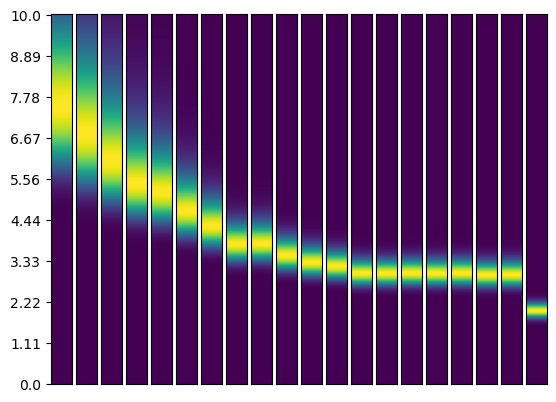

In [6]:
fig, (axes) = plt.subplots(1, len(rbf_values))
first = True
for ax, r in zip(axes, rbf_values):
    ax.imshow(r.detach().numpy().reshape(-1, 1), aspect="auto")
    ax.invert_yaxis()
    if first:
        # By ChatGPT
        ax.set_yticks(np.linspace(0, len(rbf_linspace) - 1, num=10))
        ax.set_yticklabels(np.round(np.linspace(rbf_linspace[0], rbf_linspace[-1], num=10), 2))
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    first = False

In [7]:
init_smear = ExpNormalSmearing(model.representation_model.distance_expansion.cutoff_lower,
                  model.representation_model.distance_expansion.cutoff_upper,
                  model.representation_model.distance_expansion.num_rbf,
                  model.representation_model.distance_expansion.trainable,
                  model.representation_model.distance_expansion.dtype)

init_rbf_values = init_smear.forward(torch.Tensor(rbf_linspace)).T

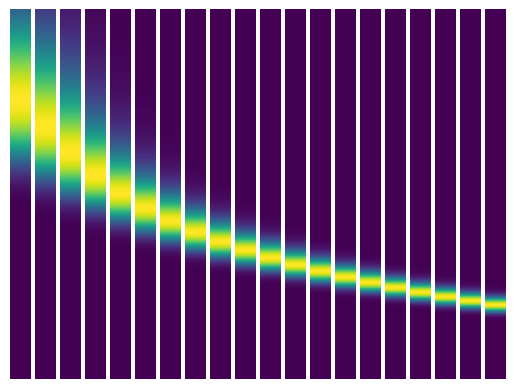

In [8]:

fig, (axes) = plt.subplots(1, len(init_rbf_values))
for ax, r in zip(axes, init_rbf_values):
    ax.imshow(r.detach().numpy().reshape(-1, 1), aspect="auto")
    ax.invert_yaxis()
    ax.axis("off")

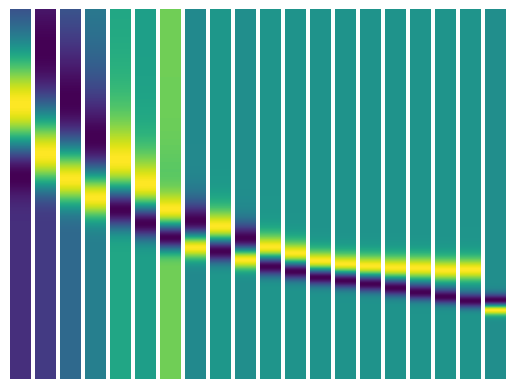

In [9]:
fig, (axes) = plt.subplots(1, len(init_rbf_values))
for ax, r in zip(axes, rbf_values-init_rbf_values):
    ax.imshow(r.detach().numpy().reshape(-1, 1), aspect="auto")
    ax.invert_yaxis()
    ax.axis("off")